In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [5]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats


In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
advanced_stats_cur = LeagueDashPlayerStats(measure_type_detailed_defense='Advanced', season='2021-22').get_data_frames()[0]

In [8]:
advanced_stats_last = LeagueDashPlayerStats(measure_type_detailed_defense='Advanced', season='2020-21').get_data_frames()[0]

In [9]:
advanced_stats_cur.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,PACE_RANK,sp_work_PACE_RANK,PIE_RANK,FGM_RANK,FGA_RANK,FGM_PG_RANK,FGA_PG_RANK,FG_PCT_RANK,CFID,CFPARAMS
0,203932,Aaron Gordon,Aaron,1610612743,DEN,26.0,27,14,13,0.519,...,454,454,198,56,91,82,108,81,5,"203932,1610612743"
1,1630565,Aaron Henry,Aaron,1610612755,PHI,22.0,1,1,0,1.000,...,8,8,480,460,459,460,443,460,5,"1630565,1610612755"
2,1628988,Aaron Holiday,Aaron,1610612764,WAS,25.0,27,14,13,0.519,...,393,393,311,205,206,252,261,151,5,"1628988,1610612764"
3,1630174,Aaron Nesmith,Aaron,1610612738,BOS,22.0,23,11,12,0.478,...,253,253,443,323,307,371,356,411,5,"1630174,1610612738"
4,1630598,Aaron Wiggins,Aaron,1610612760,OKC,22.0,9,1,8,0.111,...,320,320,433,395,406,394,401,230,5,"1630598,1610612760"


In [10]:
merged_df = pd.merge(left=advanced_stats_cur, right=advanced_stats_last, on=('PLAYER_ID', 'PLAYER_NAME'), suffixes=['_CUR', '_LAST'])

In [11]:
merged_df = merged_df.loc[(merged_df.MIN_CUR >= 20) | (merged_df.MIN_LAST >= 20)]

In [12]:
merged_df = merged_df.loc[merged_df.GP_CUR > 3]

In [13]:
merged_df.loc[:, 'USG_DIFF'] = merged_df.USG_PCT_CUR - merged_df.USG_PCT_LAST

In [14]:
merged_df.loc[:, 'TS_DIFF'] = merged_df.TS_PCT_CUR - merged_df.TS_PCT_LAST

In [15]:
merged_df.sort_values(by='TS_DIFF', ascending=True)

,PLAYER_ID,PLAYER_NAME,NICKNAME_CUR,TEAM_ID_CUR,TEAM_ABBREVIATION_CUR,AGE_CUR,GP_CUR,W_CUR,L_CUR,W_PCT_CUR,...,PIE_RANK_LAST,FGM_RANK_LAST,FGA_RANK_LAST,FGM_PG_RANK_LAST,FGA_PG_RANK_LAST,FG_PCT_RANK_LAST,CFID_LAST,CFPARAMS_LAST,USG_DIFF,TS_DIFF
345,203524,Solomon Hill,Solomon,1610612737,ATL,30.0,13,7,6,0.538,...,490,297,254,410,364,479,5,"203524,1610612737",-0.038,-0.298
271,1629008,Michael Porter Jr.,Michael,1610612743,DEN,23.0,9,5,4,0.556,...,69,35,50,44,64,70,5,"1629008,1610612743",-0.022,-0.247
368,203503,Tony Snell,Tony,1610612757,POR,30.0,22,8,14,0.364,...,437,333,344,367,402,94,5,"203503,1610612737",0.003,-0.243
366,203107,Tomas Satoransky,Tomas,1610612740,NOP,30.0,24,7,17,0.292,...,204,216,232,255,292,97,5,"203107,1610612741",-0.033,-0.218
353,201959,Taj Gibson,Taj,1610612752,NYK,36.0,12,5,7,0.417,...,216,309,353,333,408,23,5,"201959,1610612752",-0.005,-0.147
311,200794,Paul Millsap,Paul,1610612751,BKN,36.0,21,14,7,0.667,...,182,185,195,205,223,179,5,"200794,1610612743",-0.020,-0.134
348,1628425,Sterling Brown,Sterling,1610612742,DAL,26.0,20,10,10,0.500,...,305,235,229,251,246,253,5,"1628425,1610612745",-0.005,-0.134
315,1630173,Precious Achiuwa,Precious,1610612761,TOR,22.0,21,11,10,0.524,...,275,274,304,349,391,68,5,"1630173,1610612748",-0.014,-0.129
320,203493,Reggie Bullock,Reggie,1610612742,DAL,30.0,26,13,13,0.500,...,357,143,133,174,172,269,5,"203493,1610612752",-0.020,-0.128
52,1628449,Chris Boucher,Chris,1610612761,TOR,28.0,26,13,13,0.500,...,54,105,135,119,146,95,5,"1628449,1610612761",0.005,-0.128


In [16]:
lowry_id = find_players_by_full_name("Kyle Lowry")[0]['id']

In [17]:
lowry_id

200768

In [18]:
game_logs = PlayerGameLogs(player_id_nullable=lowry_id, measure_type_player_game_logs_nullable='Advanced', season_nullable='2021-22').get_data_frames()[0]

In [21]:
plt.style.use('fivethirtyeight')

In [23]:
game_logs.USG_PCT = game_logs.USG_PCT * 100
game_logs.TS_PCT = game_logs.TS_PCT * 100

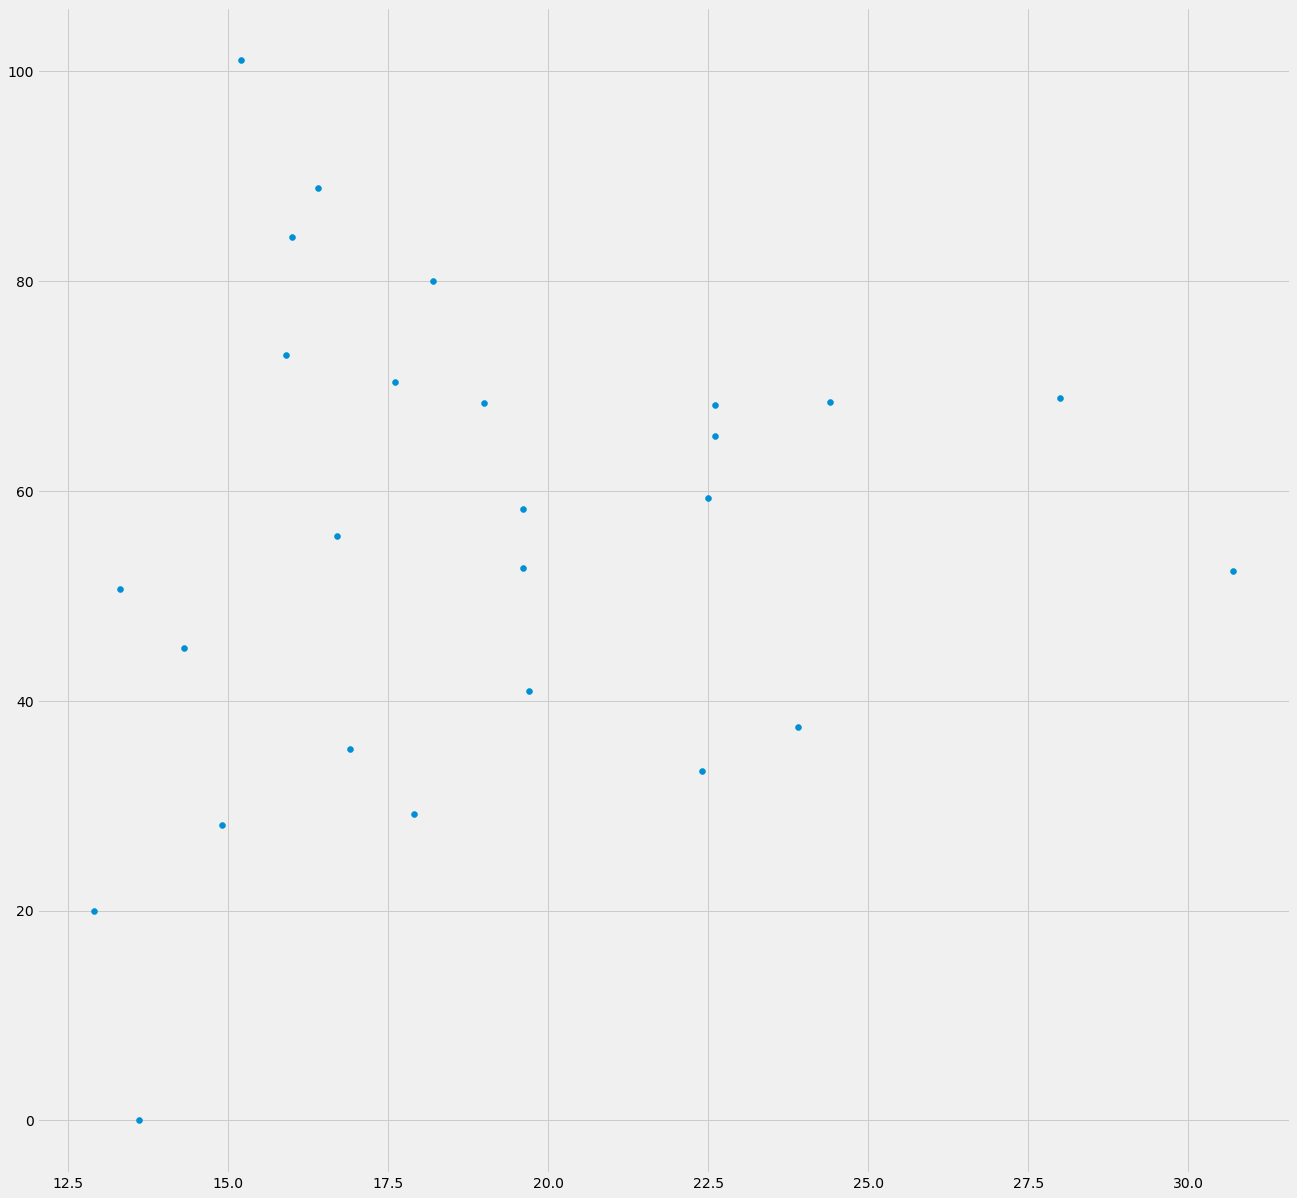

In [24]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(game_logs.USG_PCT, game_logs.TS_PCT)